# 1. Introduction

In this project, I will be utilizing the K-Means algorithm to cluster wine customers based on if they will answer to an e-mail campaign or not.

# 2. Sourcing and Loading

**2a. Import relevant libraries**

In [3]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("poster")

**2b. Load Dataset**<br>
<br>
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [4]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

**2c. Preliminary exploration of data**

In [5]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [6]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

In [7]:
merged = pd.merge(df_offers, df_transactions)
matrix = merged.pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0)
matrix.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## 3. Modelling 
In K-Means Clustering, we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. Two of these methods will be: the Elbow method and the Silhouette method.

**3a. The Elbow Method**

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. We can plot the sum of squares vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

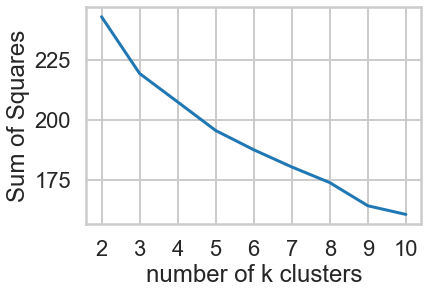

In [9]:
x_cols = matrix[matrix.columns[1:]]
from sklearn.cluster import KMeans
sse = []
k_clusters = []
for k in range(2, 11):
    km = KMeans(n_clusters=k)
    km.fit(x_cols)
    sse.append(km.inertia_)
    k_clusters.append(k)

_ = plt.plot(k_clusters, sse)
_ = plt.xlabel('number of k clusters')
_ = plt.ylabel('Sum of Squares')
_ = plt.xticks(list(range(2,11)))

The elbow in this plot is not very distinct, but there is a slight bend where k=3

**3b. 3-Cluster Barplot**

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Cluster Number')]

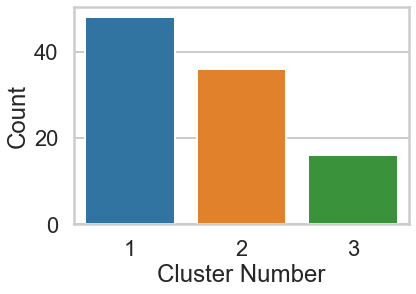

In [10]:
km = KMeans(n_clusters=3)
km.fit(x_cols)
pred = km.predict(x_cols)
import numpy as np

_ = sns.barplot(list(range(1,4)), np.bincount(pred))
_.set(xlabel='Cluster Number', ylabel='Count')

This barplot shows us how many data points would be labeled in which cluster, if we did indeed use 3 clusters as our parameter.

**3c. The Silhouette Method**

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

For n_clusters = 2 The average silhouette_score is : 0.08446953162122041
For n_clusters = 3 The average silhouette_score is : 0.1215126410281926
For n_clusters = 4 The average silhouette_score is : 0.12709723654281452
For n_clusters = 5 The average silhouette_score is : 0.12567897441142384
For n_clusters = 6 The average silhouette_score is : 0.11389961333938649
For n_clusters = 7 The average silhouette_score is : 0.11885054126106566
For n_clusters = 8 The average silhouette_score is : 0.12002012987993042
For n_clusters = 9 The average silhouette_score is : 0.13255779537299797
For n_clusters = 10 The average silhouette_score is : 0.12266359803518577


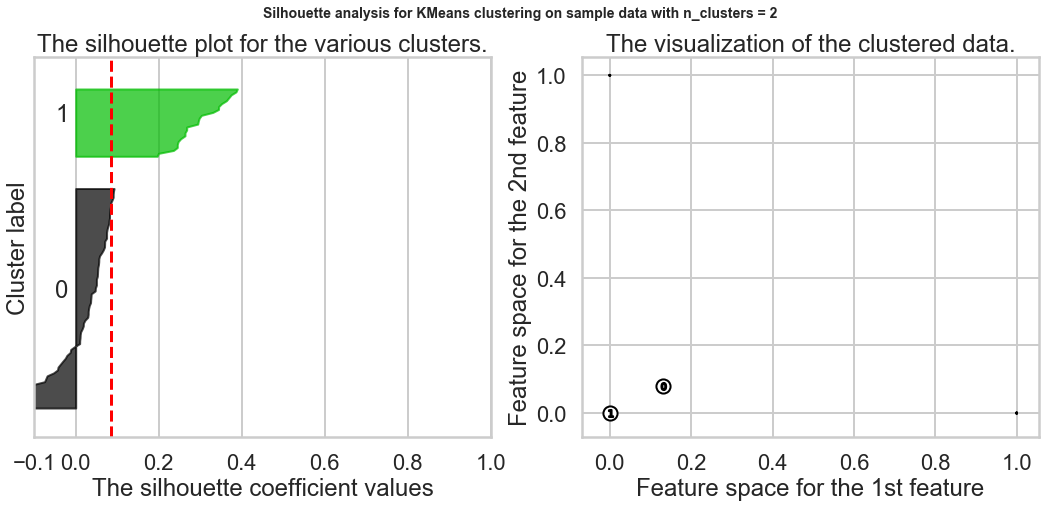

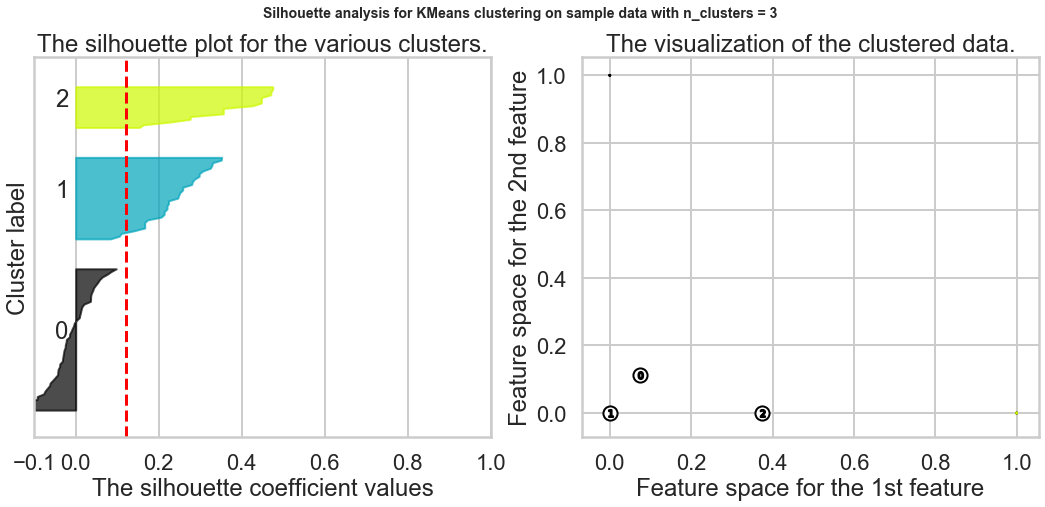

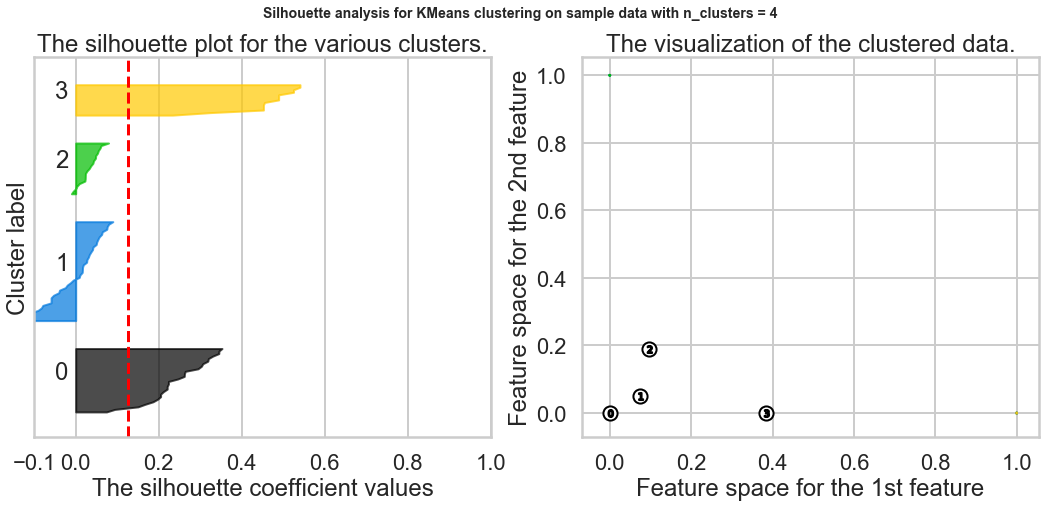

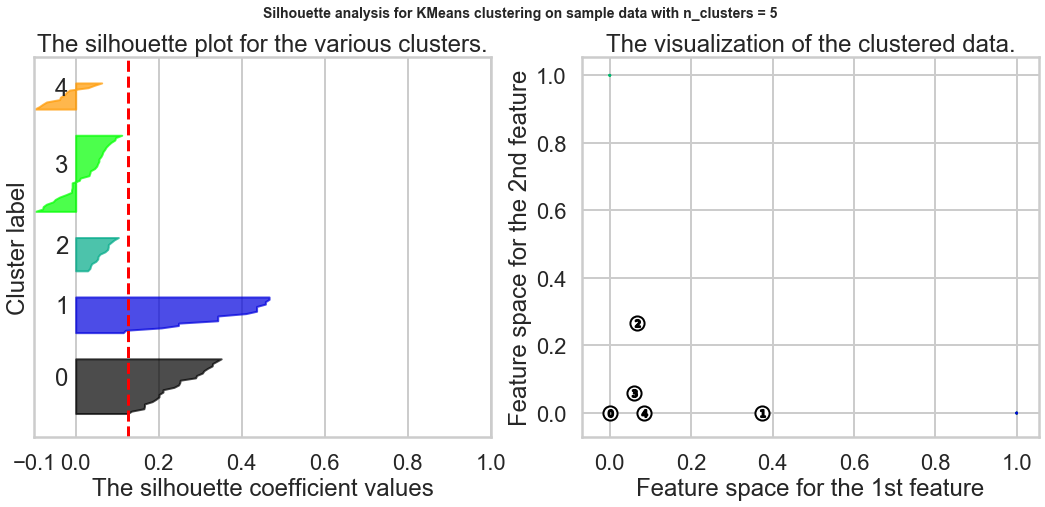

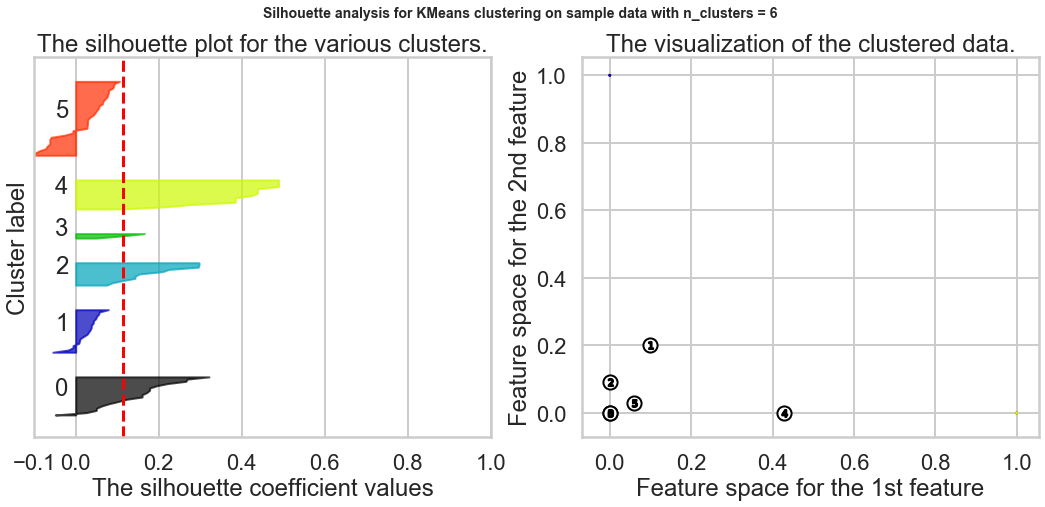

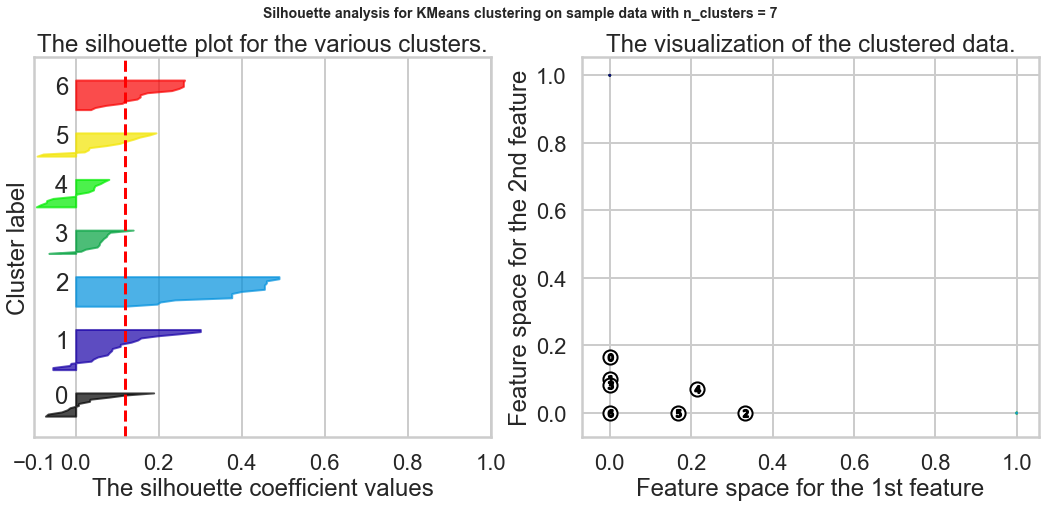

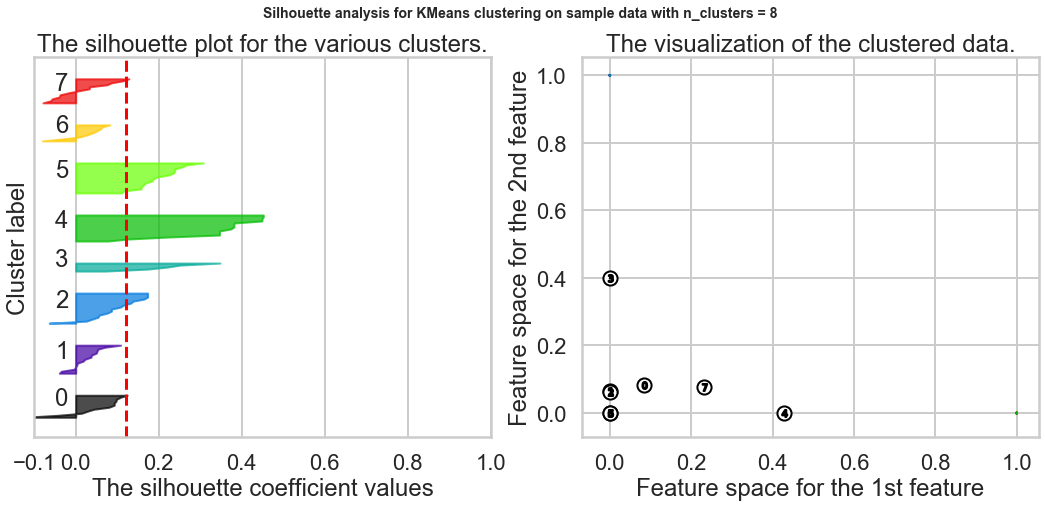

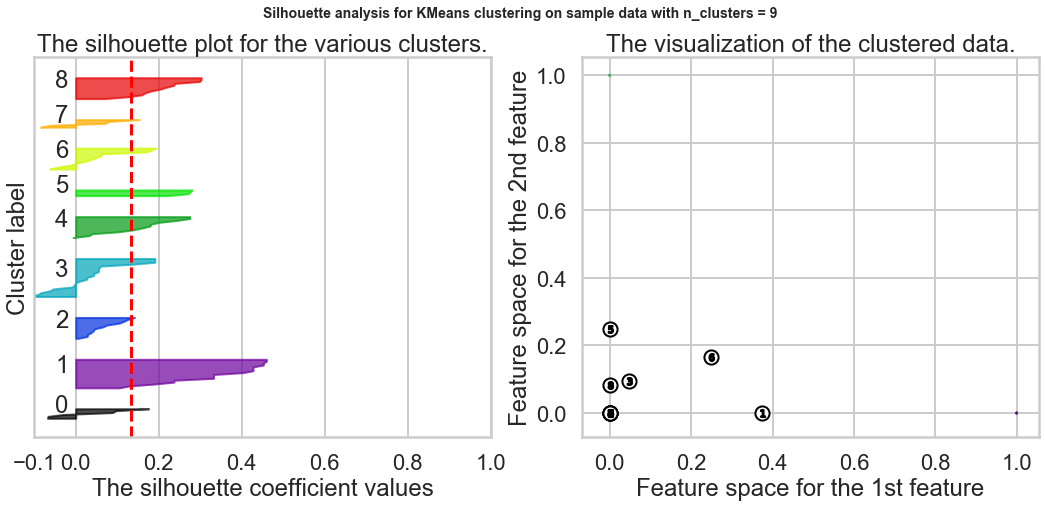

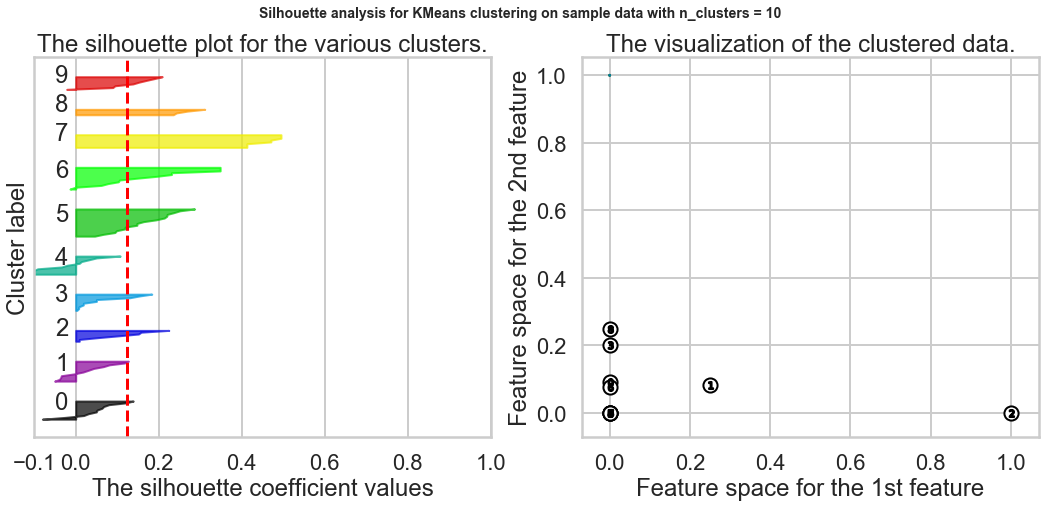

In [11]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

range_n_clusters = range(2, 11)
x_cols

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x_cols.iloc[:, 0], x_cols.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

In [12]:
scores = {}

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    scores[n_clusters] = silhouette_avg
    
print([key for key, value in scores.items() if value == max(scores.values())])

[9]


The Silhouette Method has us choose k=4, which is different from the elbow method.

# 4. Data Visualization

**4a. Visualizing Clusters using PCA**

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

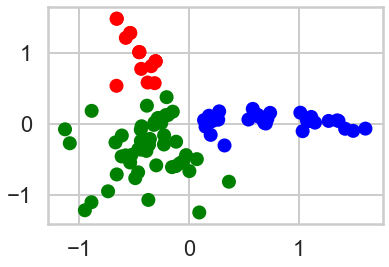

In [15]:
import sklearn.decomposition
import matplotlib.colors

X = x_cols
model = sklearn.cluster.KMeans(n_clusters=3)
cluster_assignments = model.fit_predict(X)
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])
pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))
plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)

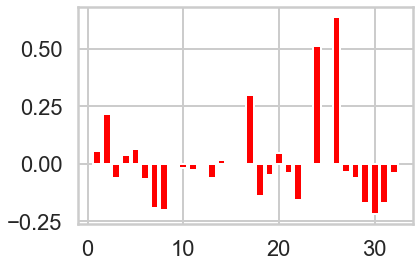

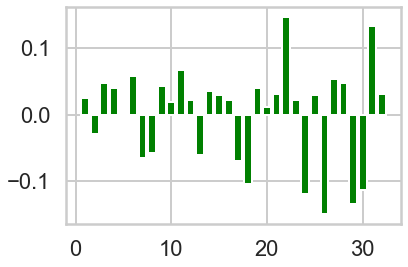

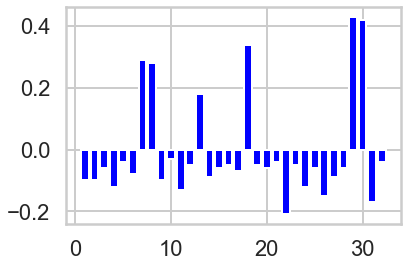

In [19]:
X = x_cols
model = sklearn.cluster.KMeans(n_clusters=3)
cluster_assignments = model.fit_predict(X)

colors = ['red', 'green', 'blue']
offer_proportions = matrix.sum(axis=0) / 100 
for i in range(3):
    plt.figure(i)
    cluster = matrix[cluster_assignments == i]
    offer_proportions_cluster = cluster.sum(axis=0) / cluster.shape[0] 
    lift = offer_proportions_cluster - offer_proportions
    plt.bar(range(1, 33), lift, color=colors[i])

What I've done is I've taken those columns of 0/1 indicator variables, and transformed them into a 2-D dataset. I took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. I color coded each point based on it's cluster so it's easier to see them.

**4b. Elbow method using explained variance**

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

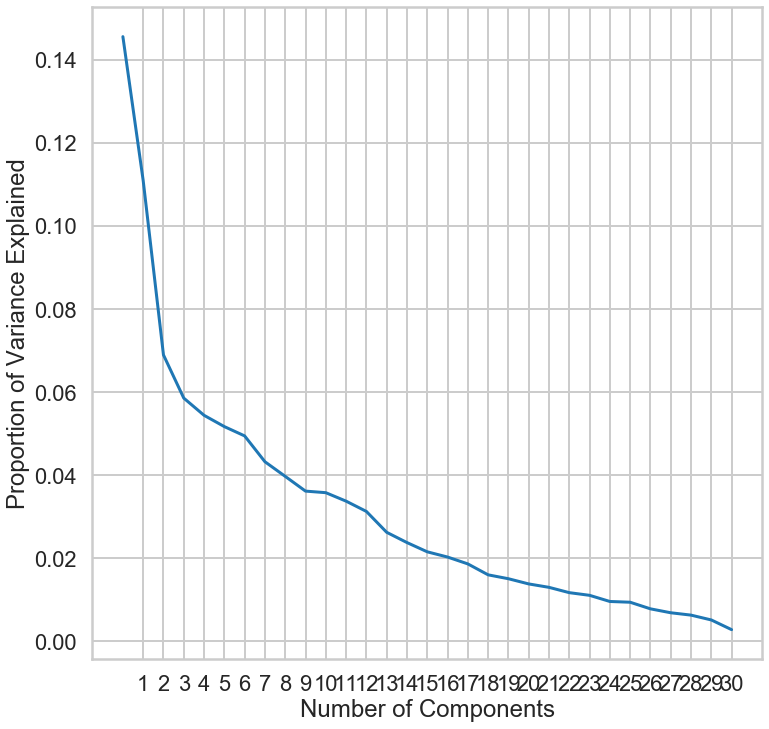

In [21]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA()
pca.fit(x_cols)
variance = pca.explained_variance_ratio_

fig = plt.figure(figsize=(12,12))
_ = plt.plot(range(len(variance)), variance)
_ = plt.xticks(list(range(1, 31)))
_ = plt.xlabel('Number of Components')
_ = plt.ylabel('Proportion of Variance Explained')

The optimal cluster count is 2 from this test

## 4. Conclusions and next steps

From these methods, we conclude that there is evidence for 2-4 clusters given this unlabeled dataset. 